# Импорты

In [1]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import pandas as pd
import seaborn as sns
from math import exp, inf, tanh
from numpy import mean, std
from scipy.stats import norm

# Модели

In [2]:
class ChangePointSequence:
    def __init__(self, N, mean, standard_deviation, change_point_position):
        self.N = N - 1
        self.counter = -1
        self.mean = mean
        self.standard_deviation = standard_deviation
        self.change_point_position = change_point_position
        self.sequence = []
        
    def __iter__(self):
        return self
    
    def __next__(self):
        pass

    
class NoChangePoint(ChangePointSequence):
    '''
    Потоковая генерация случайной последовательности без разладки.
    '''
    def __init__(self, N, mean, standard_deviation):
        super().__init__(N, mean, standard_deviation, 0)
        
    def __next__(self):
        if self.counter < self.N:
            self.counter += 1
            new_element_sequence = float(norm.rvs(loc=self.mean, scale=self.standard_deviation, size=1))             
            self.sequence.append(new_element_sequence)
            return new_element_sequence
        else:
            raise StopIteration
    

class ChagePointMean(ChangePointSequence):
    '''
    Потоковая генерация случайной последовательности с разладкой в М.О.
    '''
    def __init__(self, N, mean, standard_deviation, change_point_position, mean_change):
        super().__init__(N, mean, standard_deviation, change_point_position)
        self.mean_change = mean_change
        
    def __next__(self):
        if self.counter < self.N:
            
            self.counter += 1
            
            new_element_sequence = float(norm.rvs(loc=self.mean, scale=self.standard_deviation, size=1)) \
            if self.counter <= self.change_point_position \
            else float(norm.rvs(loc=(self.mean+self.mean_change), scale=self.standard_deviation, size=1))
            
            self.sequence.append(new_element_sequence)
            return new_element_sequence
        
        else:
            raise StopIteration
            
            
class ChagePointMeanDynamic(ChangePointSequence):
    '''
    Потоковая генерация случайной последовательности с разладкой в М.О.
    '''
    def __init__(self, N, mean, standard_deviation, change_point_position, mean_change):
        super().__init__(N, mean, standard_deviation, change_point_position)
        self.mean_change = mean_change
        
    def __next__(self):
        if self.counter < self.N:
            
            self.counter += 1
            
            new_element_sequence = float(norm.rvs(loc=self.mean, scale=self.standard_deviation, size=1)) \
            if self.counter <= self.change_point_position \
            else float(norm.rvs(loc=(self.mean+self.mean_change*(self.counter-self.change_point_position)),
                                scale=self.standard_deviation,
                                size=1))
            
            self.sequence.append(new_element_sequence)
            return new_element_sequence
            
        else:
            raise StopIteration
            
            
class ChagePointDispersion(ChangePointSequence):
    '''
    Потоковая генерация случайной последовательности с разладкой в дисперсии
    '''
    def __init__(self, N, mean, standard_deviation, change_point_position, standard_deviation_change):
        super().__init__(N, mean, standard_deviation, change_point_position)
        self.standard_deviation_change = standard_deviation_change
        
    def __next__(self):
        if self.counter < self.N:
            
            self.counter += 1
            
            new_element_sequence = float(norm.rvs(loc=self.mean, scale=self.standard_deviation, size=1)) \
            if self.counter <= self.change_point_position \
            else float(norm.rvs(loc=self.mean, scale=(self.standard_deviation+self.standard_deviation_change), size=1))
            
            self.sequence.append(new_element_sequence)
            return new_element_sequence
        
        else:
            raise StopIteration    

# Импорт нашего датасета

In [3]:
data = pd.read_csv('climate_change.csv', parse_dates=[['Year', 'Month']])
data.head()

,Year_Month,MEI,CO2,CH4,N2O,CFC-11,CFC-12,TSI,Aerosols,Temp
0,1983-05-01,2.556,345.96,1638.59,303.677,191.324,350.113,1366.1024,0.0863,0.109
1,1983-06-01,2.167,345.52,1633.71,303.746,192.057,351.848,1366.1208,0.0794,0.118
2,1983-07-01,1.741,344.15,1633.22,303.795,192.818,353.725,1366.2850,0.0731,0.137
3,1983-08-01,1.130,342.25,1631.35,303.839,193.602,355.633,1366.4202,0.0673,0.176
4,1983-09-01,0.428,340.17,1648.40,303.901,194.392,357.465,1366.2335,0.0619,0.149


In [4]:
np.mean(data['Temp'][:100])

0.11314000000000003

In [5]:
np.sqrt(np.var(data['Temp'][:100]))

0.11908316589677988

In [18]:
# Алгоритм Воробейчикова
def algorithm_change_point_St(seq, difference_step_count=10, t0=300, m=1, N=8):

    def z_n(N, m, x, t, t0):
        def sign(x):
            return 1 if x >= 0 else -1

        def y_n(x, t, t0):
            return sign(x[t] - x[t-t0])

        return N * y_n(x, t, t0) - m
    
    def dcp(difference_step_count, difference):
        if len(difference) < difference_step_count:
            return False
        previous = None
        for i in range(difference_step_count-1):
            if difference[-1-i] != difference[-2-i]:
                return False
        return True
    
    
    l = N + m
    Sn = []
    t = 0
    x = []
    difference = []
    
    while t <= t0:
        x.append(seq[t])
        Sn.append(l)
        t += 1

    while t < len(seq):
        x.append(seq[t])
        zn = z_n(N, m, x, t, t0)
        current_Sn = max(Sn[-1] + zn, l)
        difference.append((current_Sn - Sn[-1]))
        if dcp(difference_step_count, difference):
            return (t, t - difference_step_count)

        Sn.append(current_Sn)
        t += 1
        
    return (-1, -1)

In [19]:
algorithm_change_point_St(data['Temp'], t0=100, difference_step_count=15)

(144, 129)

In [10]:
def algorithm_grsh(seq, g=12, k=100):
    R = [0]

    m = mean(seq[:100])
    s = np.std(seq[:100])
    v = (abs(m) + 2*s) 
    
    for i in range(k, len(seq)):
        Rt = exp(seq[i] - v) * (1 + R[-1])
        if Rt > g:
            return i - 1
        R.append(Rt)
    return -1

In [11]:
algorithm_grsh(data['Temp'], g=12)

172

In [12]:
data['Year_Month'][172]

Timestamp('1997-09-01 00:00:00')

In [105]:
np.mean(data['Temp'][:172])

0.1341976744186047

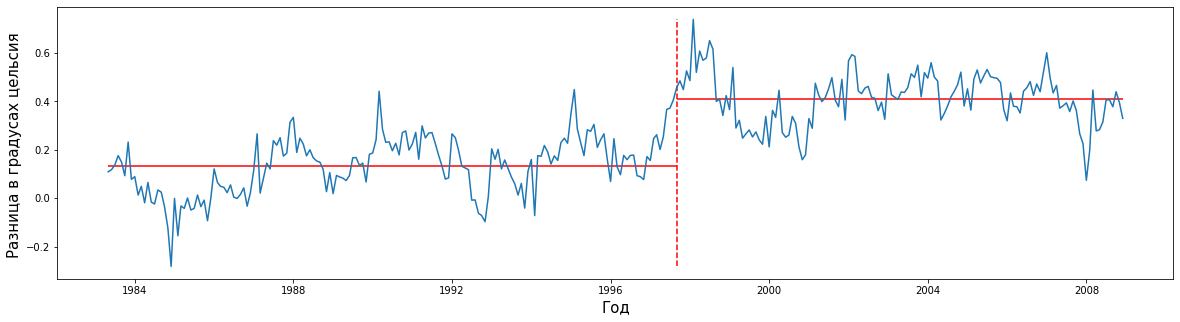

In [51]:
plt.figure(figsize=(20,5))
plt.ylabel('Разница в градусах цельсия ', fontsize=15)
plt.xlabel('Год', fontsize=15)
plt.plot(data['Year_Month'], data['Temp'])

plt.hlines(0.1341976744186047, '1983-05-01', '1997-09-01', color = 'r') 

plt.hlines(0.41180147058823513, '1997-09-01', '2008-12-01', color = 'r')

plt.vlines('1997-09-01', data['Temp'].min(), data['Temp'].max(), color = 'r', linestyles='dashed') 

plt.show()

In [39]:
data['Year_Month'][129]

Timestamp('1994-02-01 00:00:00')

C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


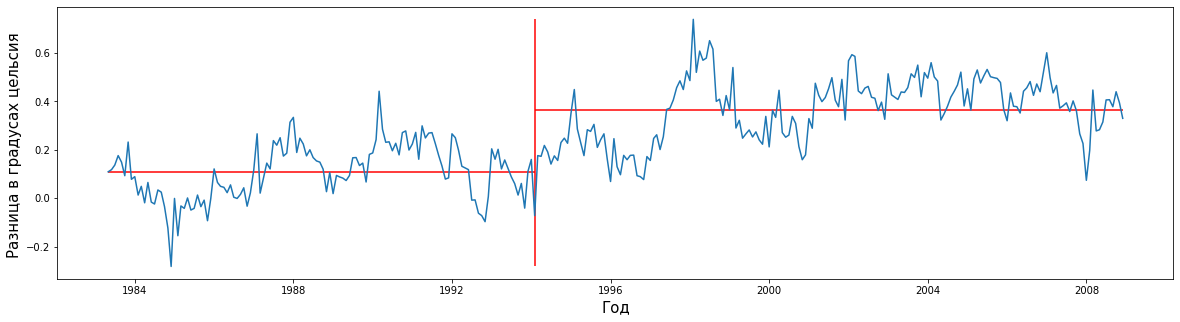

In [44]:
plt.figure(figsize=(20,5))
plt.ylabel('Разница в градусах цельсия ', fontsize=15)
plt.xlabel('Год', fontsize=15)
plt.plot(data['Year_Month'], data['Temp'])

plt.hlines(np.mean(data['Temp'][:129]), '1983-05-01', '1994-02-01', color = 'r') 

plt.hlines(np.mean(data['Temp'][129:]), '1994-02-01', '2008-12-01', color = 'r')

plt.vlines('1994-02-01', data['Temp'].min(), data['Temp'].max(), color = 'r') 

plt.show()

In [43]:
data['Year_Month'][162]

Timestamp('1996-11-01 00:00:00')

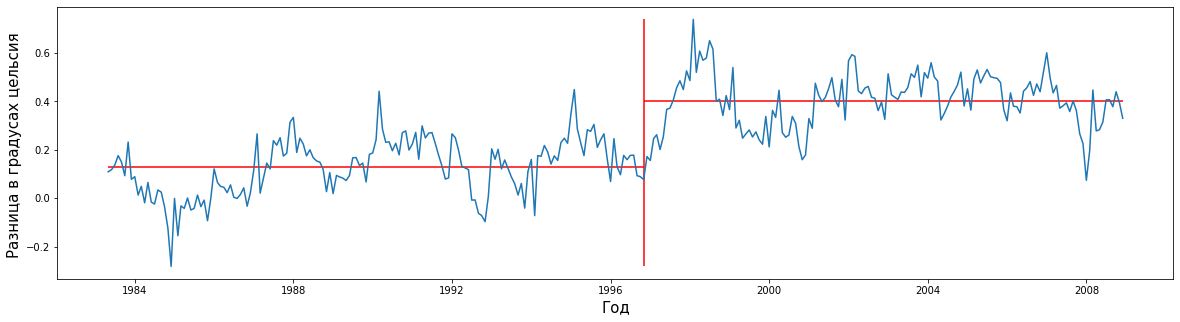

In [45]:
plt.figure(figsize=(20,5))
plt.ylabel('Разница в градусах цельсия ', fontsize=15)
plt.xlabel('Год', fontsize=15)
plt.plot(data['Year_Month'], data['Temp'])

plt.hlines(np.mean(data['Temp'][:162]), '1983-05-01', '1996-11-01', color = 'r') 

plt.hlines(np.mean(data['Temp'][162:]), '1996-11-01', '2008-12-01', color = 'r')

plt.vlines('1996-11-01', data['Temp'].min(), data['Temp'].max(), color = 'r') 

plt.show()

In [49]:
data['Year_Month'][198]

Timestamp('1999-11-01 00:00:00')

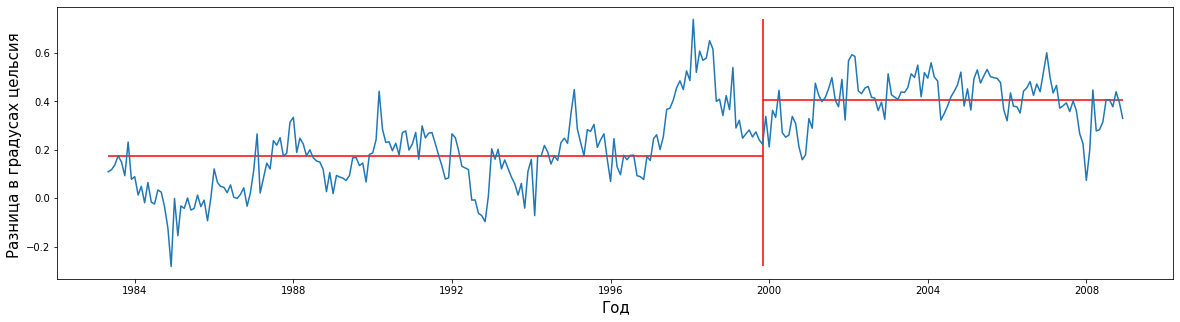

In [50]:
plt.figure(figsize=(20,5))
plt.ylabel('Разница в градусах цельсия ', fontsize=15)
plt.xlabel('Год', fontsize=15)
plt.plot(data['Year_Month'], data['Temp'])

plt.hlines(np.mean(data['Temp'][:198]), '1983-05-01', '1999-11-01', color = 'r') 

plt.hlines(np.mean(data['Temp'][198:]), '1999-11-01', '2008-12-01', color = 'r')

plt.vlines('1999-11-01', data['Temp'].min(), data['Temp'].max(), color = 'r') 

plt.show()

In [8]:
def algorithm_grsh(seq, g=12, k=100):
    R = [0]
    i = 0 
    
    # Заполняем изначальными значениями
    while len(sequence.sequence) < k:
        new_value = next(sequence)

    from numpy import mean, std
    m = mean(sequence.sequence)
    s = np.std(sequence.sequence)
    v = (abs(m) + 2*s) 
    
    for new_value in seq:
        Rt = exp(new_value - v) * (1 + R[-1])
        if Rt > g:
            #print('changepoint', seq.counter - 1, 'Rt =', Rt)
            return seq.counter - 1
        R.append(Rt)
    #print('No change points.')
    return -1

In [9]:
g_list = [8,8.1,8.2,8.3,8.4,8.5,8.6,8.7,8.8,8.9,9,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10]

for g in g_list:
    lst = []
    for i in range(1000):    
        sequence = ChagePointMean(
        N=500,
        mean=0.11314000000000003, 
        standard_deviation=0.11908316589677988, 
        change_point_position=250, 
        mean_change=0.5)

        result = algorithm_grsh(seq=sequence, g=g, k=100)
        lst.append(result)

    lst_freq = [x for x in lst if x < 200]
    false_detection_probability = len(lst_freq)/1000

    print('Вероятность ложного обнаружения =', false_detection_probability,'g=', g)

Вероятность ложного обнаружения = 0.044 g= 8
Вероятность ложного обнаружения = 0.031 g= 8.1
Вероятность ложного обнаружения = 0.024 g= 8.2
Вероятность ложного обнаружения = 0.022 g= 8.3
Вероятность ложного обнаружения = 0.021 g= 8.4
Вероятность ложного обнаружения = 0.03 g= 8.5
Вероятность ложного обнаружения = 0.02 g= 8.6
Вероятность ложного обнаружения = 0.014 g= 8.7
Вероятность ложного обнаружения = 0.012 g= 8.8
Вероятность ложного обнаружения = 0.008 g= 8.9
Вероятность ложного обнаружения = 0.008 g= 9
Вероятность ложного обнаружения = 0.012 g= 9.1
Вероятность ложного обнаружения = 0.004 g= 9.2
Вероятность ложного обнаружения = 0.007 g= 9.3
Вероятность ложного обнаружения = 0.003 g= 9.4
Вероятность ложного обнаружения = 0.004 g= 9.5
Вероятность ложного обнаружения = 0.008 g= 9.6
Вероятность ложного обнаружения = 0.004 g= 9.7
Вероятность ложного обнаружения = 0.005 g= 9.8
Вероятность ложного обнаружения = 0.003 g= 9.9
Вероятность ложного обнаружения = 0.002 g= 10


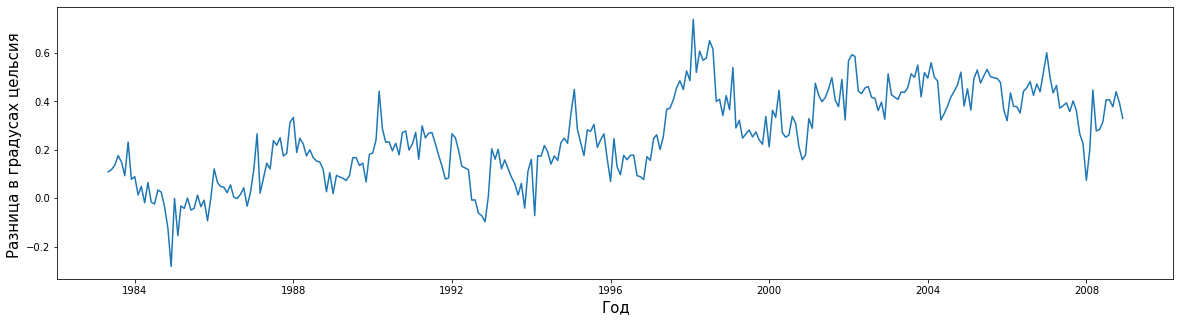

In [50]:
plt.figure(figsize=(20,5))
plt.ylabel('Разница в градусах цельсия ', fontsize=15)
plt.xlabel('Год', fontsize=15)
plt.plot(data['Year_Month'], data['Temp'])

# data['Year_Month'][algorithm_grsh(data['Temp'])]

# Алгоритм CUSUM bootstrap

In [14]:
def algorithm_CUSUM_bootstrap(seq, confidence_level=95, number_bootstrap_samples=1000):
    sequence = seq
    
    mean_y = np.mean(sequence)

    CUSUM = np.asarray([yi - mean_y for yi in sequence])
    CUSUM = np.cumsum(CUSUM)

    CUSUM_max = np.max(CUSUM)
    CUSUM_min = np.min(CUSUM)
    CUSUM_diff = CUSUM_max - CUSUM_min

    count = 0
    for i in range(number_bootstrap_samples):
        new_y = np.random.permutation(sequence)
        new_CUSUM = np.asarray([yi - mean_y for yi in new_y])
        new_CUSUM = np.cumsum(new_CUSUM)

        new_CUSUM_max = np.max(new_CUSUM)
        new_CUSUM_min = np.min(new_CUSUM)
        new_CUSUM_diff = new_CUSUM_max - new_CUSUM_min
        if new_CUSUM_diff < CUSUM_diff:
            count += 1

    confidence_level_calc = (count / number_bootstrap_samples) * 100
    if confidence_level_calc > confidence_level:
        abs_CUSUM = np.fabs(CUSUM)
        CUSUM_max = np.max(abs_CUSUM)
        change_point = int(np.where(abs_CUSUM == CUSUM_max)[0]) 
#         print('Точка разладки:', change_point)
        return change_point
    else: 
        return -1

In [16]:
sequence = data['Temp']
change_point = algorithm_CUSUM_bootstrap(sequence, 90, 1000)
change_point

168

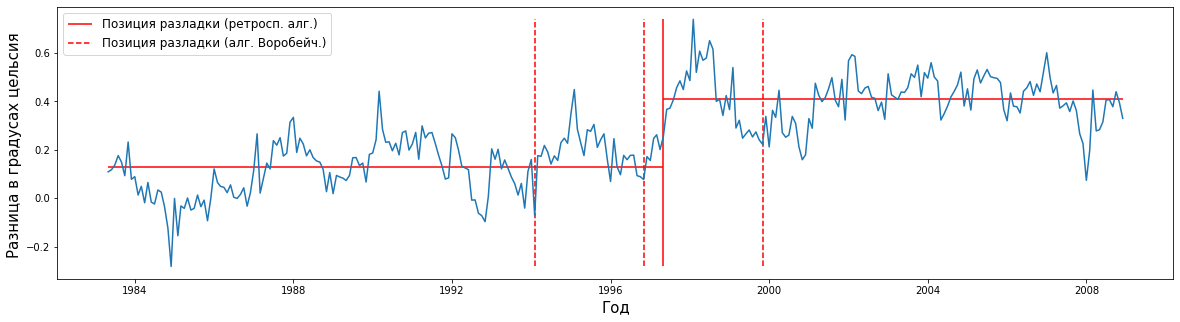

In [60]:
plt.figure(figsize=(20,5))
plt.ylabel('Разница в градусах цельсия ', fontsize=15)
plt.xlabel('Год', fontsize=15)
plt.plot(data['Year_Month'], data['Temp'])

plt.hlines(0.12906547619047623, '1983-05-01', '1997-05-01', color = 'r') 

plt.hlines(0.41002857142857135, '1997-05-01', '2008-12-01', color = 'r')

plt.vlines('1997-05-01', data['Temp'].min(), data['Temp'].max(), color = 'r', label='Позиция разладки (ретросп. алг.)') 


plt.vlines('1994-02-01', data['Temp'].min(), data['Temp'].max(), color = 'r', linestyles='dashed', 
           label='Позиция разладки (алг. Воробейч.)') 
plt.vlines('1996-11-01', data['Temp'].min(), data['Temp'].max(), color = 'r', linestyles='dashed') 

plt.vlines('1999-11-01', data['Temp'].min(), data['Temp'].max(), color = 'r', linestyles='dashed') 


plt.legend(fontsize=12) 
plt.show()

# Алгоритм Боровкова

In [41]:
def algorithm_change_point_Q(seq):
    
    f_1 = seq
    S_1_m = np.cumsum(f_1)
    
    f_2 = [y ** 2 for y in f_1]
    S_2_m = np.cumsum(f_2)
    
    Q1 = []
    Q2 = []
    n = len(f_1)
    
    for t in range(n):
        sum_Q = 0
        for i in range(0, t+1):
            sum_Q += (f_1[i] - S_1_m[t]/t) ** 2
            
        for i in range(t+1, n):
            sum_Q += (f_1[i] - (S_1_m[n-1]-S_1_m[t])/(n-t)) ** 2
        
        Q1.append(sum_Q)
        
    for t in range(n):
        sum_Q = 0
        for i in range(0, t+1):
            sum_Q += (f_2[i] - S_2_m[t]/t) ** 2
            
        for i in range(t+1, n):
            sum_Q += (f_2[i] - (S_2_m[n-1]-S_2_m[t])/(n-t)) ** 2
        
        Q2.append(sum_Q)
        
    Q = [q1+q2 for q1,q2 in zip(Q1,Q2)]
    
    min_Q = np.min(Q)
    change_point = int(np.where(Q == min_Q)[0]) # +1 ?
    return change_point
    

In [42]:
sequence = data['Temp']
change_point = algorithm_change_point_Q(sequence)
change_point

C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()
C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars


168

# Алгоритм, основанный на информационном подходе

In [44]:
def algorithm_fa(seq, type_cp='mean'):
    sequence = seq
    
    n = len(sequence)
    tau = np.arange(1,n)
    lmbd = 2*np.log(n) #Bayesian Information Criterion
    eps = 1.e-8 #to avoid zeros in denominator
    
    if type_cp =="mean":
        mu0 = np.mean(sequence)
        s0 = np.sum((sequence-mu0)**2)
        s1 = np.asarray([np.sum((sequence[0:i]-np.mean(sequence[0:i]))**2) for i in range(1,n)])
        s2 = np.asarray([np.sum((sequence[i:]-np.mean(sequence[i:]))**2) for i in range(1,n)])
        R  = s0-s1-s2
        G  = np.max(R)
        taustar = int(np.where(R==G)[0]) 
        sd1 = np.std(sequence[0:taustar-1])
        sd2 = np.std(sequence[taustar-1:])
        var = ( taustar*sd1**2 + (n-taustar)*sd2**2 ) / n
        criterion = lmbd # var*lmbd
         
    elif type_cp =="var":
        std0 = np.std(sequence)
        std1 = np.asarray([np.std(sequence[0:i]) for i in range(1,n)],dtype=float) + eps
        std2 = np.asarray([np.std(sequence[i:]) for i in range(1,n)],dtype=float) + eps
        R = n*np.log(std0) - tau*np.log(std1) - (n-tau)*np.log(std2)
        G  = np.max(R)
        taustar = int(np.where(R==G)[0])
        criterion = lmbd
        
    if 2*G >= criterion:
        return taustar
    else:
        return -1


In [45]:
sequence = data['Temp']
change_point = algorithm_fa(sequence)
change_point

168

# Алгоритм ГРШ

In [9]:
def algorithm_grsh(seq, g=12, k=100):
    R = [0]
    i = 0 
    
    # Заполняем изначальными значениями
    while len(sequence.sequence) < k:
        new_value = next(sequence)

    from numpy import mean, std
    m = mean(sequence.sequence)
    s = np.std(sequence.sequence)
    v = (abs(m) + 2*s) 
    
    for new_value in seq:
        Rt = exp(new_value - v) * (1 + R[-1])
        if Rt > g:
            #print('changepoint', seq.counter - 1, 'Rt =', Rt)
            return seq.counter - 1
        R.append(Rt)
    #print('No change points.')
    return -1

In [10]:
sequence = ChagePointMeanDynamic(N=1000, mean=1, standard_deviation=1, change_point_position=400, mean_change=1/2)

algorithm_grsh(data['Temp'], 12, 100)

-1

# Алгоритм Воробейчикова

In [59]:
# Алгоритм Воробейчикова
def algorithm_change_point_St(seq, difference_step_count=10, t0=300, m=1, N=8):

    def z_n(N, m, x, t, t0):
        def sign(x):
            return 1 if x >= 0 else -1

        def y_n(x, t, t0):
            return sign(x[t] - x[t-t0])

        return N * y_n(x, t, t0) - m
    
    def dcp(difference_step_count, difference):
        if len(difference) < difference_step_count:
            return False
        previous = None
        for i in range(difference_step_count-1):
            if difference[-1-i] != difference[-2-i]:
                return False
        return True
    
    
    l = N + m
    Sn = []
    t = 0
    x = []
    difference = []
    
    while t <= t0:
        x.append(next(sequence))
        Sn.append(l)
        t += 1

    for new_value in sequence:
        x.append(new_value)
        zn = z_n(N, m, x, t, t0)
        current_Sn = max(Sn[-1] + zn, l)
        difference.append((current_Sn - Sn[-1]))
        if dcp(difference_step_count, difference):
            return (t, t - difference_step_count)

        Sn.append(current_Sn)
        t += 1
        
    return (-1, -1)

In [23]:
sequence = ChagePointMean(N=1000, mean=1, standard_deviation=1, change_point_position=400, mean_change=2)

algorithm_change_point_St(sequence, 10)[0]

410

In [163]:
[a/20 for a in range(10, 71, 5)]

[0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5]

In [141]:
[a/20 for a in range(10, 61, 5)]

[0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]

In [164]:
[a/20 for a in range(10, 71, 5)]

[0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5]